# 16-14. 프로젝트 : SRGAN 활용하기

---

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

#### 1. 고해상도 이미지 불러오기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import os

이미지크기 :  (576, 1024, 3)


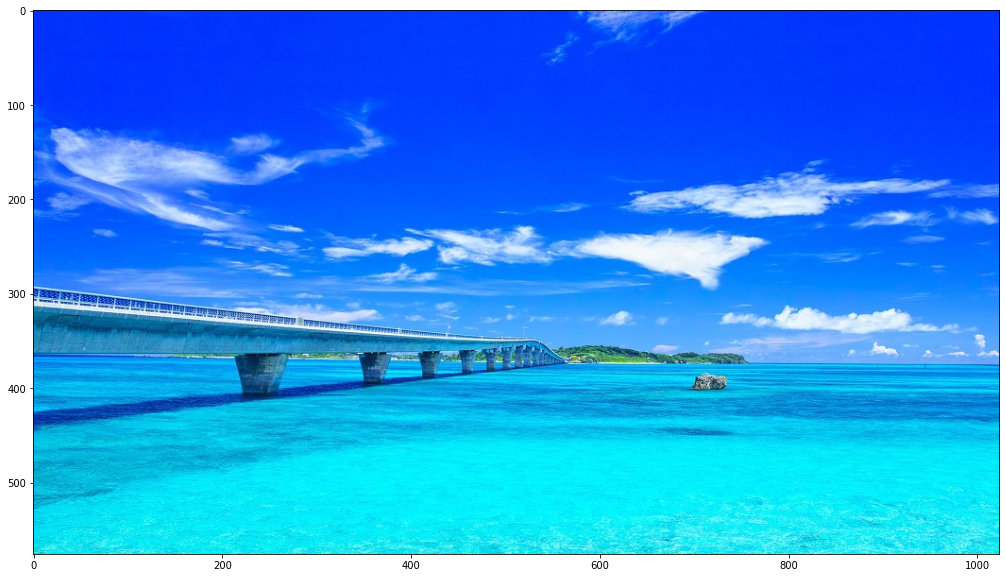

In [2]:
image_path = os.getenv('HOME') + '/aiffel/super_resolution/blue.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('이미지크기 : ', image.shape)
plt.figure(figsize=(20,10))
plt.imshow(image)

#### 2. bicubic interpolation을 적용과 1/4 리사이즈

리사이즈된 이미지크기 :  (144, 256, 3)


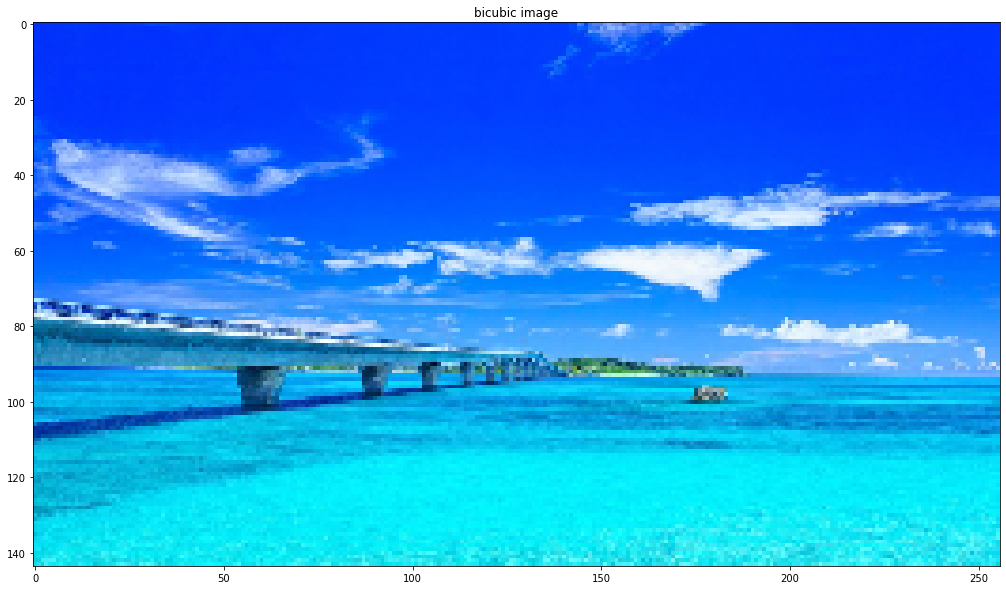

In [3]:
bicubic_lr = cv2.resize(image, dsize=(image.shape[1] // 4,image.shape[0] // 4), interpolation=cv2.INTER_CUBIC) # bicubic interpolation 적용

print('리사이즈된 이미지크기 : ',bicubic_lr.shape)

plt.figure(figsize=(20,10))
plt.title('bicubic image')
plt.imshow(bicubic_lr)

#### 3.  SRGAN을 이용해 고해상도 이미지를 생성

In [4]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [6]:
srgan_hr = apply_srgan(bicubic_lr)

srgan 이미지크기 :  (576, 1024, 3)


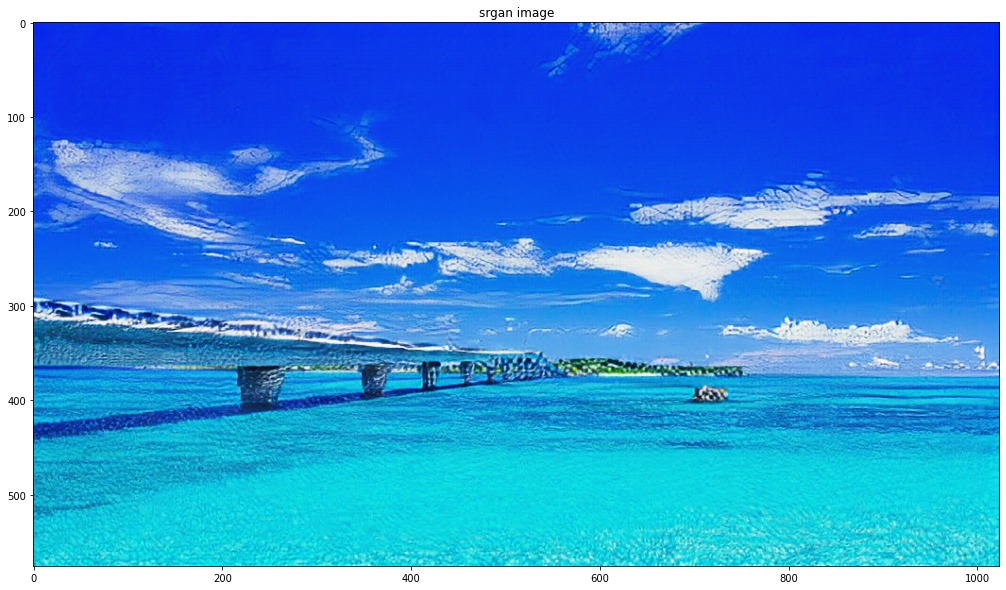

In [7]:
print('srgan 이미지크기 : ',srgan_hr.shape)

plt.figure(figsize=(20,10))
plt.title('srgan image')
plt.imshow(srgan_hr)

#### 4.  2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 4배로 늘리기

bicubic: (576, 1024, 3)


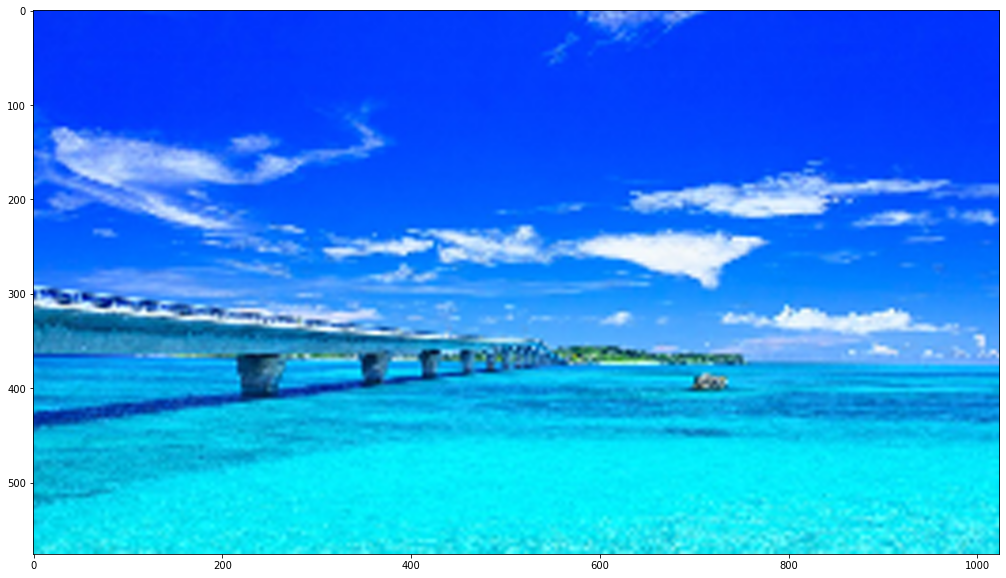

In [8]:
bicubic_hr = cv2.resize(bicubic_lr, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC) # 원본사이즈로 복원
print('bicubic:', bicubic_hr.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr)

#### 5.  시각화(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)

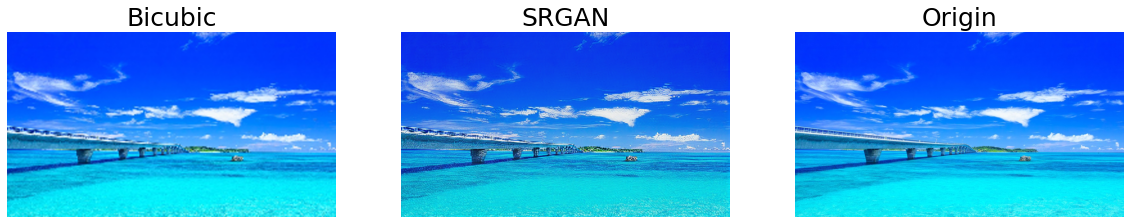

In [9]:
images = [bicubic_hr, srgan_hr, image]
titles = ["Bicubic", "SRGAN", "Origin"]

plt.figure(figsize=(20,10))

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=25)
    plt.axis('off')

In [10]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

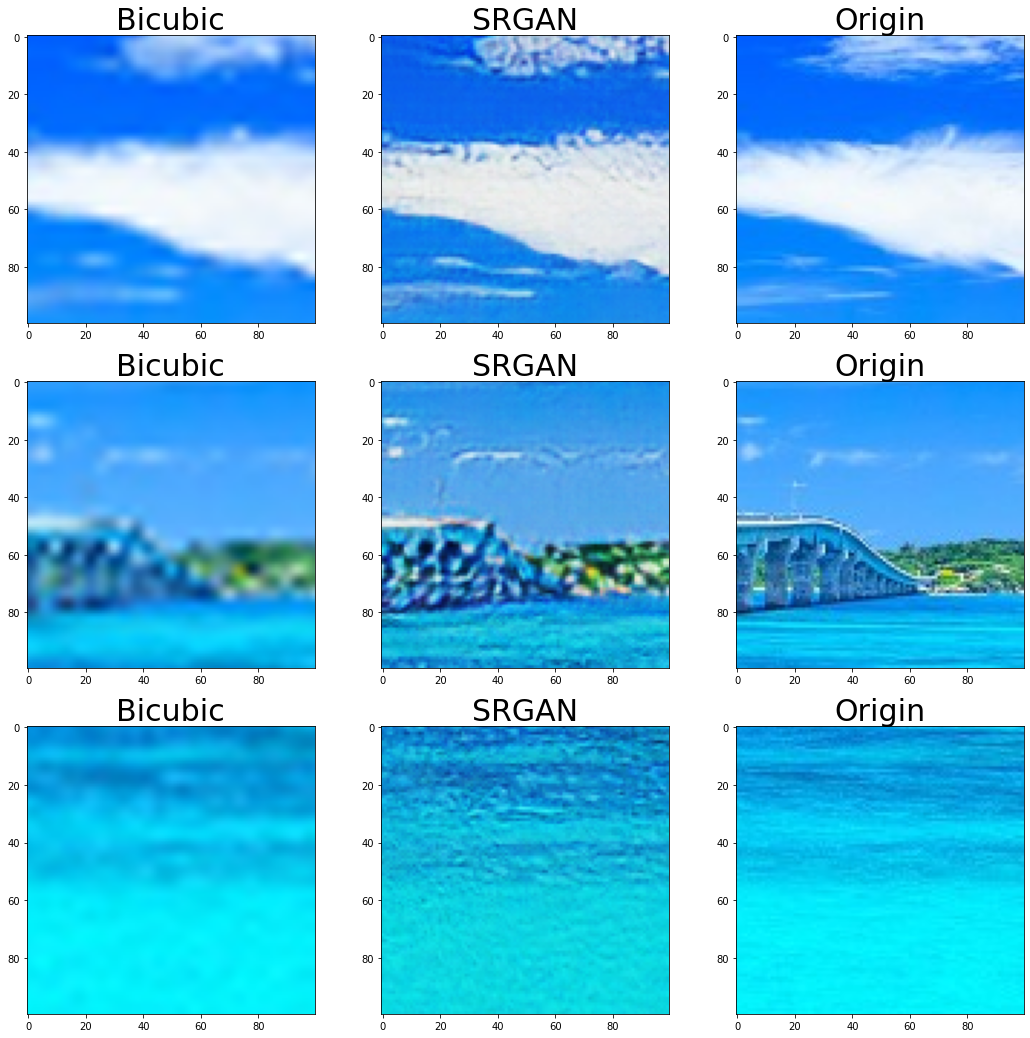

In [11]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,600), (300,500), (400,500)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 100, 100)
    img2 = crop(srgan_hr , left_top, 100, 100)
    img3 = crop(image, left_top, 100, 100)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "Origin"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 6. 결과 분석

- 전체 이미지로는 Bicubic, SRGAN 모두 잘 복원한 듯 하였으나. 확대시 차이가 느껴진다.
- Bicubic은 자연스러우나 화질 저화질이라는 생각이 들며, SRGAN은 그림판으로 그린 그림처럼 픽셀 단위로 색칠된 것 같다.
- 해상도 측면에서 보면 SRGAN이 더 잘 만들어진 것으로 생각해야 될 것 같고 모델을 불러오는 것에 더해 하이퍼파라미터를 조정해서 시도해봐야 할 것 같다.


- 궁금한게 1/4로 리사이즈를 해봤는데 1/8과 1/2 리사이즈로 시도해봤을 경우 어떤 결과가 나올지 확인해 보고 싶다.
- 키워주고자하는 배수가 커질 수록 효과가 좋다고 하고, 찾아보니 1/16도 있는데 이부분은 직접 시도 해보는 게 좋을 것 같다.

### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

#### 1. 저해상도 이미지 불러오기

이미지크기 :  (420, 409, 3)


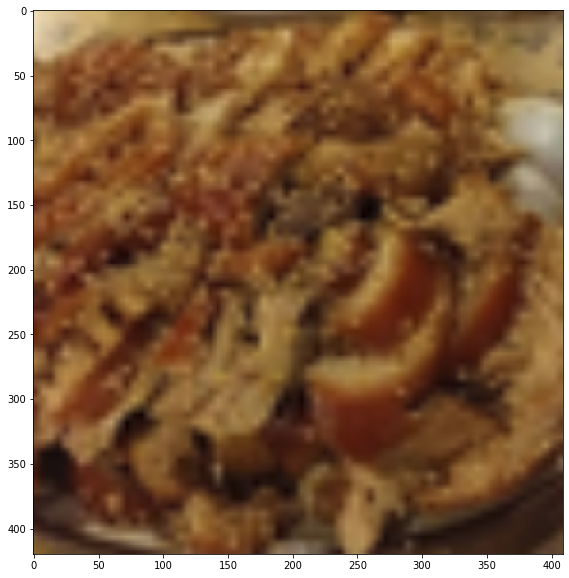

In [12]:
image_path = os.getenv('HOME') + '/aiffel/super_resolution/Jokbal.png'
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
print('이미지크기 : ', image2.shape)
plt.figure(figsize=(20,10))
plt.imshow(image2)

#### 2.  SRGAN을 이용해 고해상도 이미지를 생성

In [13]:
bicubic_lr2 = cv2.resize(image2, dsize=(image2.shape[1] // 4,image2.shape[0] // 4), interpolation=cv2.INTER_CUBIC) # bicubic interpolation 적용

In [14]:
srgan_hr2 = apply_srgan(bicubic_lr2)

srgan 이미지크기 :  (420, 408, 3)


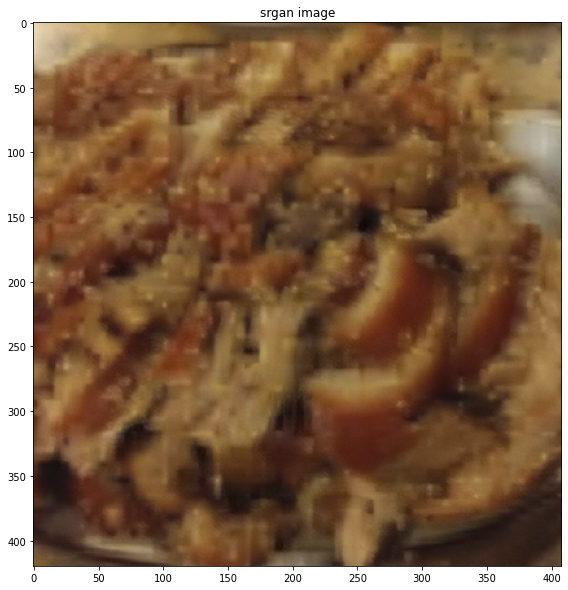

In [15]:
print('srgan 이미지크기 : ',srgan_hr2.shape)

plt.figure(figsize=(20,10))
plt.title('srgan image')
plt.imshow(srgan_hr2)

#### 3.  1.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 4배로 늘리기

bicubic: (420, 409, 3)


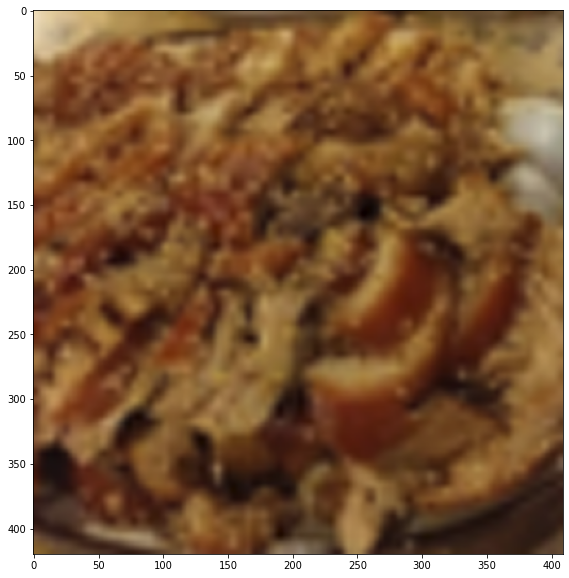

In [16]:
bicubic_hr2 = cv2.resize(bicubic_lr2, dsize=(image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_CUBIC) # 원본사이즈로 복원
print('bicubic:', bicubic_hr2.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr2)

#### 4. 시각화(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)

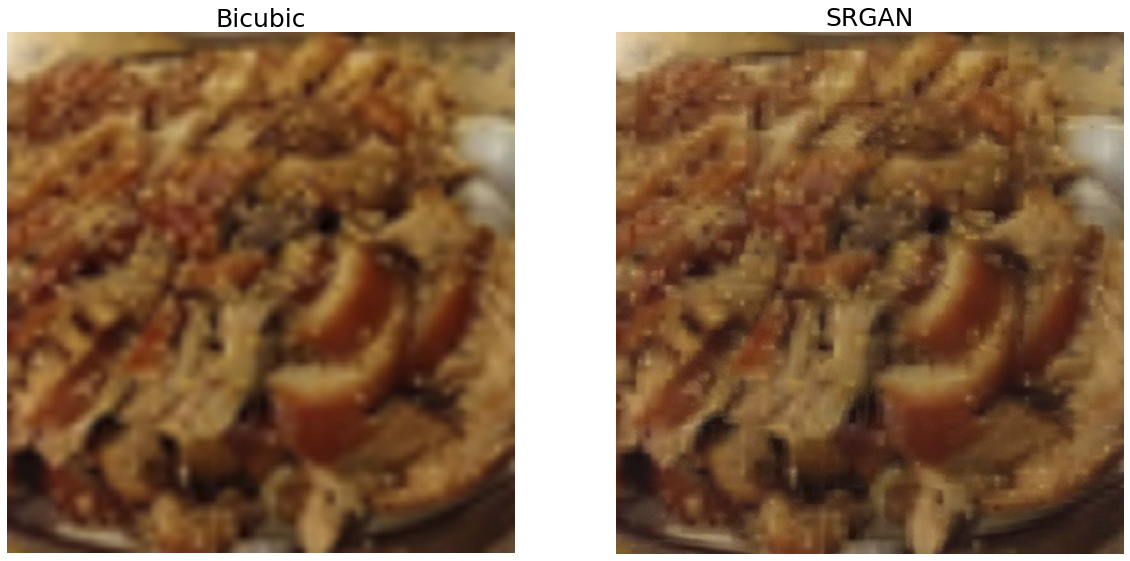

In [17]:
images = [bicubic_hr2, srgan_hr2]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(20,10))

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=25)
    plt.axis('off')

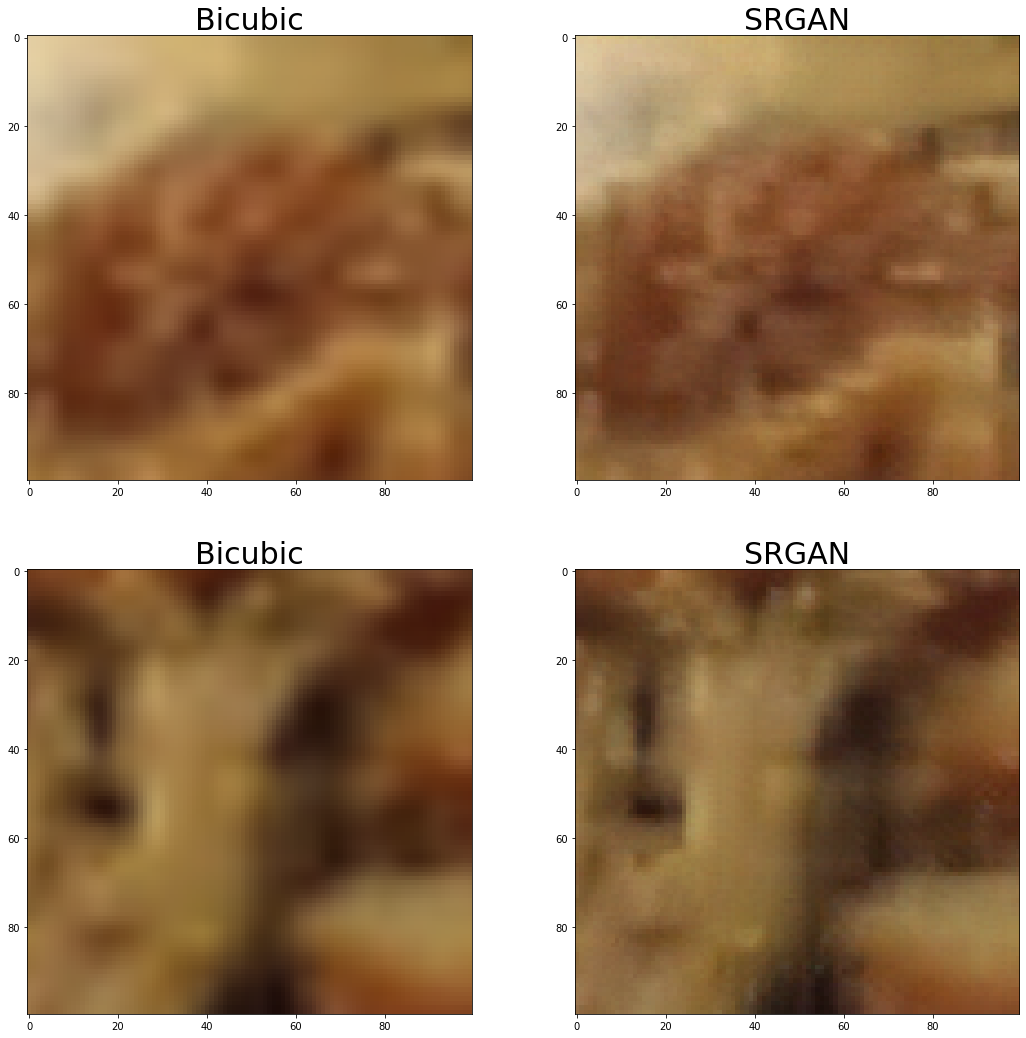

In [18]:
# 자세히 시각화 하기 위해 2개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 2개 입니다.
left_tops = [(0,10), (200,150)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr2, left_top, 100, 100)
    img2 = crop(srgan_hr2 , left_top, 100, 100)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 2

plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(2,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 6. 결과 분석

- SRGAN이 더 선명하다.
- 저화질을 탈출할 줄 알았으나 여전히 화질은 낮다.
- 그래도 원본이미지보다 더 나아진 것 같다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### 1. gif 파일 불러오기

In [19]:
# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME')+'/aiffel/super_resolution'
gif = cv2.VideoCapture(gif_path + '/city_night_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


### 2. 프레임별 Super Resolution 진행하기

- Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. 
- Super Resolution이 완료된 각각의 결과를 `frames_sr`이라는 리스트에 넣어주세요.

In [20]:
frames_sr_bicubic = []
for i in frames: 
    bi_i = cv2.resize(i, dsize=(i.shape[1]*4, i.shape[0]*4), interpolation=cv2.INTER_CUBIC) 
    frames_sr_bicubic.append(bi_i)

In [21]:
frames_sr_srgan = []
for i in frames: 
    srgan_i = apply_srgan(i)
    frames_sr_srgan.append(srgan_i)

### 3. 프레임을 합쳐 gif 만들기

In [22]:
import imageio

imageio.mimsave(gif_path + "/city_night_hr_bicubic.gif", frames_sr_bicubic)
imageio.mimsave(gif_path + "/city_night_hr_srgan.gif", frames_sr_srgan)

### 4. Jupyter notebook에 gif 표시하기

In [23]:
from IPython.display import Image as show_gif

# show_gif(gif_path + "/city_night_lr.gif", width=400) # width 는 적당히 큰 값으로 설정해주세요

In [24]:
# show_gif(gif_path + "/city_night_hr_bicubic.gif", width=400)

In [25]:
# show_gif(gif_path + "/city_night_hr_srgan.gif", width=400)

1. 원본
![origin](/EXPLORATION_16/city_night_lr.gif)
2. bicubic
![bicubic](/EXPLORATION_16/city_night_hr_bicubic.gif)
3. srgan
![srgan](/EXPLORATION_16/city_night_hr_srgan.gif)

### 5. 결과분석

- bicubic의 경우 좀더 그림같은 느낌이 든다.
- 이미지가 너무 현란하게 움직여서 비교하기 어렵기에 다른 이미지도 시도해봤다.

In [26]:
# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME')+'/aiffel/super_resolution'
gif = cv2.VideoCapture(gif_path + '/fire_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frames_sr_bicubic = []
for i in frames: 
    bi_i = cv2.resize(i, dsize=(i.shape[1]*4, i.shape[0]*4), interpolation=cv2.INTER_CUBIC) 
    frames_sr_bicubic.append(bi_i)
    
frames_sr_srgan = []
for i in frames: 
    srgan_i = apply_srgan(i)
    frames_sr_srgan.append(srgan_i)
    
imageio.mimsave(gif_path + "/fire_hr_bicubic.gif", frames_sr_bicubic)
imageio.mimsave(gif_path + "/fire_hr_srgan.gif", frames_sr_srgan)

frame 수 : 14
frame 크기 : (282, 300, 3)


In [27]:
# show_gif(gif_path + "/fire_lr.gif", width=400) # width 는 적당히 큰 값으로 설정해주세요

In [28]:
# show_gif(gif_path + "/fire_hr_bicubic.gif", width=400)

In [29]:
# show_gif(gif_path + "/fire_hr_srgan.gif", width=400)

1. 원본
![origin](/EXPLORATION_16/fire_lr.gif)
2. bicubic
![bicubic](/EXPLORATION_16/fire_hr_bicubic.gif)
3. srgan
![srgan](/EXPLORATION_16/fire_hr_srgan.gif)

- 우측 상단 불빛이 깜빡이는 부분을 보면 bicubic은 픽셀이 좀더 큰 덩어리로 깜빡이는 걸 볼 수 있다.
- 이외에도 낙엽이나 장작 등을 보면 SRGAN이 아주 조금더 선명하게 느껴진다.

---

## 루브릭 관련 고려한 점

**1. SRGAN을 이용해 고해상도의 이미지를 생성하였다**

- SRGAN을 통해 생성된 이미지를 제출하였다.

**2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.**

- 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.

**3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.**

- 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.

## 회고
1️⃣ 잘한 점:

- cv2.resize()에서 dsize에 부분에서 (image.shape[1],image.shape[0])으로 수정했다.
- 일반적인 가로세로라고 당연히 생각하고 진행했으나 만들어진 이미지 비율이 엉망이라 확인하는 과정에서 알게되었다.
- 근데 gif에서도 같은 실수를 반복해서 또 수정했다.
- 그래도 먼저 고친게 있어서 좀더 빠르게 수정할 수 있었다.
- 그냥 사용하던 코드에 있어 당연한건 없다고 느끼고 더 꼼꼼히 볼 수 있었다.

2️⃣ 어려웠던 점:

- 각 모델이 작동되는 과정에 대한 이해가 더 필요하다.
- bicubic도 srgan을 비교할 때 눈으로 크게 분간이 안되는 바다(프로젝트 1번 고화질 이미지) 쪽 같은 경우에는 위치를 재지정하고 판단했다.
- 단일, 비슷한 색으로 이루어진 곳보다는 여러가지 색과 형체를 띈 물건인 경우가 구분이 쉽게 된다.
- 용량이 커서 깃에 바로 안올라가서 저장 후 마크다운을 통해 gif 사진을 올렸다.
- 마크다운 `![이름](이미지주소)`로 올리니까 사진 1개만 올라가고 나머지는 깨지는 현상이 발생되었는데 지식전파자 이우용님과 우용님께 해결방법을 알려준 최진영님 덕분에 해결할 수 있었다.
- 깃허브에 올렸으면 `![이름](/업로드된디렉토리명/파일명)` 이렇게 올리면 해결되었다.


3️⃣ 느낀 점:

- 이미지로 결과를 비교하는 과정은 언제나 뿌듯하다.
- bicubic도 srgan도 해상도를 올리는 결과물을 내지만 srgan이 더 우수하다.
- 저해상도 이미지를 복원하는데는 상대적인 어려움이 있다.
- 보간법에 대해 잘 몰랐는데 이번 기회에 다시 공부할 수 있었다.